## Семинар: различные имплементации градиентного бустинга

* XGboost + подбор гиперпараметров
* CatBoost + SHAP
* LightGBM

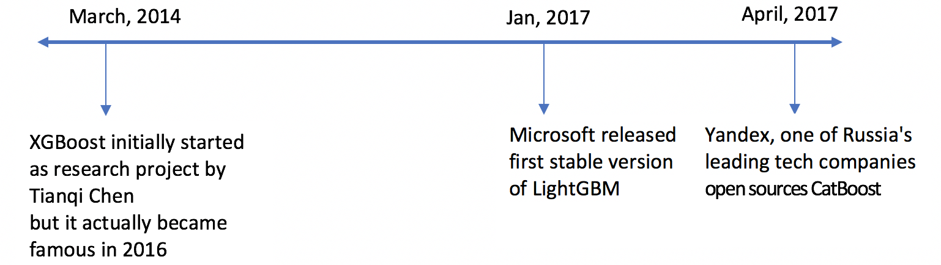!["История"](bst.png)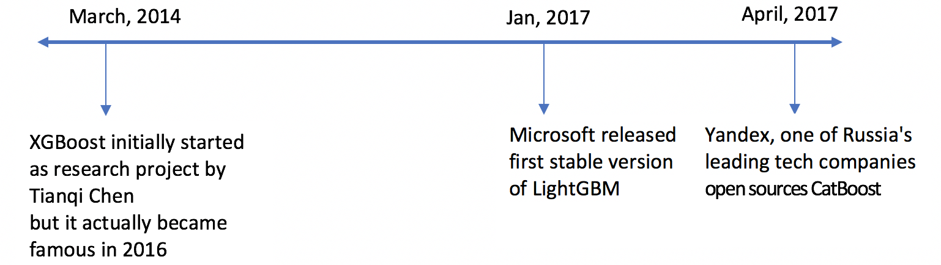

## 1. XGboost + подбор гиперпараметров

Код по xgboost основан на статье https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Основные особенности xgboost:
* базовый алгоритм приближает направление, посчитанное с учетом второй производной функции потерь

* функционал регуляризуется – добавляются штрафы за количество листьев и за норму коэффициентов

* при построении дерева используется критерий информативности, зависящий от оптимального вектора сдвига

* критерий останова при обучении дерева также зависит от оптимального сдвига

Почитать подробнее тут: https://github.com/esokolov/ml-course-hse/blob/master/2020-fall/lecture-notes/lecture10-ensembles.pdf

In [1]:
!pip install xgboost

In [2]:
import pandas as pd
import os
import numpy as np
from matplotlib import pylab as plot
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

Будем решать задачу классификации: по различным характеристикам клиента попытаемся определить, выплатит клиент долг или нет.

In [3]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('./train_modified.csv')
X_train = df.iloc[:24365]
X_test = df.iloc[24365:24366+10443]
len(X_train), len(X_test)

(24365, 10444)

In [4]:
X_train.head()

,Disbursed,Existing_EMI,ID,Loan_Amount_Applied,Loan_Tenure_Applied,Monthly_Income,Var4,Var5,age,EMI_Loan_Submitted_missing,...,Var1_16,Var1_17,Var1_18,Var2_0,Var2_1,Var2_2,Var2_3,Var2_4,Var2_5,Var2_6
0,0.0,0.0,0,300000.0,5.0,20000,1,0,41.713895,1,...,0,0,0,0,0,0,0,0,0,1
1,0.0,0.0,2,200000.0,2.0,35000,3,13,34.338125,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,0.0,5,600000.0,4.0,22500,1,0,38.329911,1,...,0,0,0,0,1,0,0,0,0,0
3,0.0,0.0,6,1000000.0,5.0,35000,3,10,32.191650,1,...,0,0,0,0,1,0,0,0,0,0
4,0.0,25000.0,7,500000.0,2.0,100000,3,17,35.975359,1,...,0,0,0,0,1,0,0,0,0,0


Для того, чтобы бустинг показал хорошее качество и не переобучился, необходимо аккуратно подобрать его гиперпараметры.

Алгоритм подбора гиперпараметров следующий:

* Выбираем относительно большую learning_rate ($ \eta \in [0.05, 0.3]$), подбираем оптимальное число деревьев для выбранного $ \eta $

* Настраиваем параметры деревьев, начиная с самых значимых (max_depth, min_child_weight, gamma, subsample, colsample_bytree)

* Настраиваем регуляризации ($ \lambda, \alpha $)

* Уменьшаем learning_rate, пропорционально увеличиваем число деревьев

In [5]:
model_xgb = XGBClassifier(learning_rate=0.1,
                          n_estimators=150,
                          objective= 'binary:logistic',
                          nthread=-1,
                          scale_pos_weight=1,
                          seed=27)

In [6]:
target='Disbursed'
IDcol = 'ID'

In [7]:
X_train['Disbursed'].value_counts(), len(X_train)

(Disbursed
 0.0    23989
 1.0      376
 Name: count, dtype: int64,
 24365)

Создадим функцию для моделирования и кросс-валидации

Эта функция делает следующее:
1. обучает модель
2. вычисляет accuracy на тренировочной выборке
3. вычисляет AUC на тренировочной выборке
4. вычисляет AUC на тестовой выборке
5. обновляет n_estimators с помощью встроенной в пакет xgboost функции cv
6. строит диаграмму Feature Importance

In [8]:
from sklearn import metrics

def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, \
             early_stopping_rounds=50):

    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='auc',
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0], eval_metric='auc')

    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))

    #Predict on testing data:
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest['Disbursed'], dtest['predprob']))

    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Начинаем последовательный подбор параметров при большом learning_rate


Model Report
Accuracy : 0.9846
AUC Score (Train): 0.925426
AUC Score (Test): 0.808874


/var/folders/6k/wpzb0pwn71g3ww4by8xqvb6h0000gn/T/ipykernel_84747/2749882274.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]


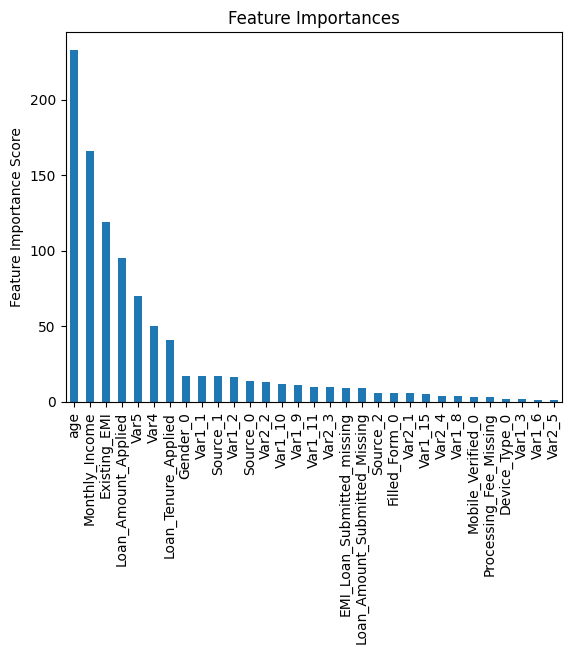

In [9]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

modelfit(model_xgb, X_train, X_test, predictors)

Перебираем max_depth и min_child_weight по сетке.

In [10]:
[i for i in range(2,7,2)]

[2, 4, 6]

In [11]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
    'max_depth':range(2,7,2),
    'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test1,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch1.fit(X_train[predictors],X_train[target])

gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 4, 'min_child_weight': 1}, np.float64(0.8209475410835033))

Уточняем предсказание

In [12]:
param_test2 = {
    'max_depth': [3, 4, 5],
    'min_child_weight': [2, 3, 4]
}

gsearch2 = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test2,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch2.fit(X_train[predictors],X_train[target])
gsearch2.best_params_, gsearch2.best_score_

({'max_depth': 4, 'min_child_weight': 2}, np.float64(0.820507946984464))

Зафиксируем найденный max_depth и min_child_weight

In [13]:
model_xgb.max_depth = 4
model_xgb.min_child_weight = 1

Мы подобрали max_depth и min_child_weight - дальше будем использовать подобранные значения параметров. Подберите по сетке параметр gamma на отрезке от 0 до 1.

In [14]:
param_test3 = {
    'gamma': np.linspace(0, 1, 5)
}

gsearch3b = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test3,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch3b.fit(X_train[predictors],X_train[target])

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=4,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=42,
                                     n_jobs=None, nthread=-1, ...),
             n_jobs=-1,
             param_grid={'gamma': array([0.  , 0.25, 0.5 , 0.75, 1.  ])},
             scoring='roc_auc')

In [15]:
gsearch3b.best_params_, gsearch3b.best_score_

({'gamma': np.float64(0.0)}, np.float64(0.8209475410835033))

Установите в качестве параметра алгоритма подобранyю gamma и посмотрите как изменилось качество.


Model Report
Accuracy : 0.9846
AUC Score (Train): 0.875391
AUC Score (Test): 0.811042


/var/folders/6k/wpzb0pwn71g3ww4by8xqvb6h0000gn/T/ipykernel_84747/2749882274.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]


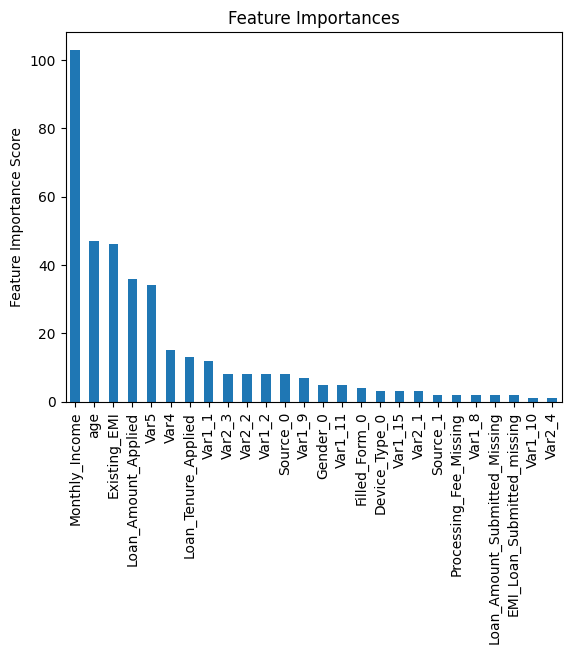

In [16]:
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

modelfit(model_xgb, X_train, X_test, predictors)

Подберите по сетке параметры subsample и colsample_bytree. Используйте значения этих параметров: [0.6,0.7,0.8,0.9,1.]

In [17]:
param_test4 = {
    'subsample':[0.6,0.7,0.8,0.9,1.],
    "colsample_bytree": [0.6,0.7,0.8,0.9,1.]
}

gsearch3b = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test4,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch3b.fit(X_train[predictors],X_train[target])

gsearch3b.best_params_, gsearch3b.best_score_

({'colsample_bytree': 0.6, 'subsample': 1.0}, np.float64(0.8238613729071848))

In [18]:
model_xgb.colsample_bytree = 0.6
model_xgb.subsample = 1.0

Подберите параметр регуляризации reg_alpha. Попробуйте [1e-5, 1e-2, 0.1, 1, 100]

In [19]:
param_test4 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}

gsearch3b = GridSearchCV(estimator=model_xgb,
                        param_grid=param_test4,
                        scoring='roc_auc',
                        n_jobs=-1,
                        cv=5)

gsearch3b.fit(X_train[predictors],X_train[target])

gsearch3b.best_params_, gsearch3b.best_score_

({'reg_alpha': 1e-05}, np.float64(0.8238613729071848))

In [20]:
model_xgb.reg_alpha = 1e-5

Запустите обучение и предсказание на найденных параметрах и посмотрите на качество.


Model Report
Accuracy : 0.9846
AUC Score (Train): 0.877783
AUC Score (Test): 0.808195


/var/folders/6k/wpzb0pwn71g3ww4by8xqvb6h0000gn/T/ipykernel_84747/2749882274.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]


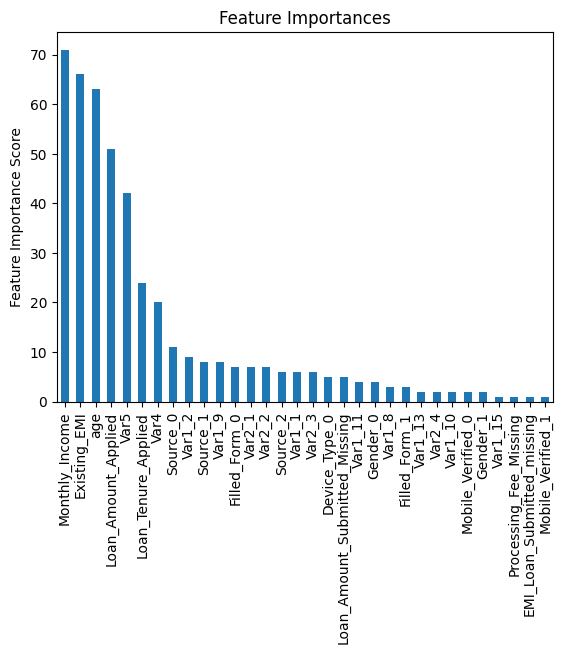

In [21]:
modelfit(model_xgb, X_train, X_test, predictors)

Уменьшите learning_rate до 0.01 и пропорционально увеличьте число деревьев. Все подобранные параметры остаются такими же. Обучите модель и сделайте предсказание. Посмотрите на качество.


Model Report
Accuracy : 0.9846
AUC Score (Train): 0.890255
AUC Score (Test): 0.815839


/var/folders/6k/wpzb0pwn71g3ww4by8xqvb6h0000gn/T/ipykernel_84747/2749882274.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]


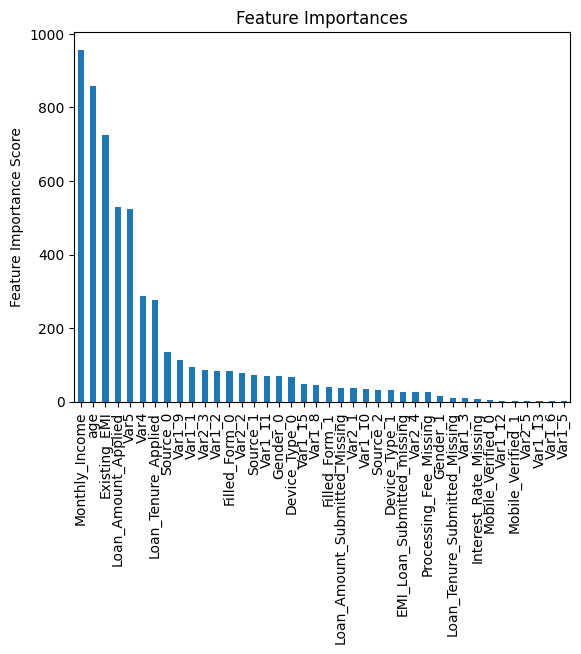

In [22]:
model_xgb.learning_rate = 0.01
model_xgb.n_estimators = 1500
modelfit(model_xgb, X_train, X_test, predictors)

## 2. CatBoost

Оригинальный ноутбук здесь: https://github.com/catboost/tutorials/blob/master/classification/classification_tutorial.ipynb

Особенности катбуста:

* используются симметричные деревья решений

* для кодирования категориальных признаков используется большой набор методов

* динамический бустинг

Благодаря использованию симметричных деревьев и динамическому бустингу катбуст гораздо более устойчив к переобучению, чем другие имплементации градиентного бустинга. Поэтому он показывает хорошее качество даже при дефолтных параметрах.

Посмотреть видео про катбуст: https://yandex.ru/video/preview/?filmId=10919886479285152550&from=tabbar&text=catboost+анна+вероника

Устанавливаем библиотеки

In [23]:
!pip install --upgrade catboost
!pip install --upgrade ipywidgets
!pip install shap
!pip install scikit-learn
!pip install --upgrade numpy
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [24]:
from matplotlib import pylab as plt

In [25]:
import pandas as pd
import os
import numpy as np
np.set_printoptions(precision=4)
import catboost
from catboost import *
from catboost import datasets

Считываем данные. Данные содержат только категориальные признаки, причем с большим количеством категорий. Признаки - закодированные характеристики сотрудника и некоторого ресурса, целевая переменная - есть ли у сотрудника доступ к ресурсу.

In [26]:
(train_df, test_df) = catboost.datasets.amazon()

In [27]:
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Готовим данные

In [28]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

Создаем список категориальных фичей

In [29]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7, 8]


Смотрим на соотношение классов

In [30]:
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

Labels: {0, 1}
Zero count = 1897, One count = 30872


Способы создать Pool - объект, содержащий матрицу объект-признак X, вектор ответов, список номеров колонок с категориальными признаками.

In [31]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(data=X, cat_features=cat_features)

# Fastest way to create a Pool is to create it from numpy matrix.
# This way should be used if you want fast predictions
# or fastest way to load the data in python.

X_prepared = X.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str

pool3 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) +
      '\ndataset 3: ' + str(pool3.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names())
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


Разбиваем данные на train и validation

In [32]:
from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

Выбираем функцию потерь

Для бинарной классификации можем использовать:

* `Logloss`

* `CrossEntropy`

In [33]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=10,
    learning_rate=0.1
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 10, 'learning_rate': 0.1}


Печать результатов

In [34]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

0:	learn: 0.6189879	test: 0.6185816	best: 0.6185816 (0)	total: 5.73ms	remaining: 51.5ms
1:	learn: 0.5585149	test: 0.5574616	best: 0.5574616 (1)	total: 11ms	remaining: 44ms
2:	learn: 0.5082799	test: 0.5069499	best: 0.5069499 (2)	total: 12.5ms	remaining: 29.2ms
3:	learn: 0.4660897	test: 0.4643558	best: 0.4643558 (3)	total: 15ms	remaining: 22.5ms
4:	learn: 0.4304632	test: 0.4282709	best: 0.4282709 (4)	total: 17.7ms	remaining: 17.7ms
5:	learn: 0.4002849	test: 0.3979354	best: 0.3979354 (5)	total: 20.1ms	remaining: 13.4ms
6:	learn: 0.3745697	test: 0.3720454	best: 0.3720454 (6)	total: 21.3ms	remaining: 9.14ms
7:	learn: 0.3525686	test: 0.3498882	best: 0.3498882 (7)	total: 23.3ms	remaining: 5.83ms
8:	learn: 0.3336944	test: 0.3308677	best: 0.3308677 (8)	total: 24.2ms	remaining: 2.69ms
9:	learn: 0.3174817	test: 0.3145131	best: 0.3145131 (9)	total: 25.6ms	remaining: 0us

bestTest = 0.3145131058
bestIteration = 9



Визуализация метрик

In [35]:
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Сравнение моделей

In [37]:
model1 = CatBoostClassifier(
    learning_rate=0.1,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.1'
)

model2 = CatBoostClassifier(
    learning_rate=0.07,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.07'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
    plot=True

)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Оптимальное количество деревьев

In [38]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [39]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 92


Кросс-валидация

In [40]:
from catboost import cv

params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1674879003
bestIteration = 36

Training on fold [1/5]

bestTest = 0.1642588398
bestIteration = 56

Training on fold [2/5]

bestTest = 0.1531042161
bestIteration = 63

Training on fold [3/5]

bestTest = 0.1426916182
bestIteration = 78

Training on fold [4/5]

bestTest = 0.1560519524
bestIteration = 55



In [41]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.226879,0.007618,0.228406,0.005219,0.640026,0.046937
2,2,0.189560,0.005706,0.195723,0.004473,0.797855,0.011978
3,3,0.178061,0.006784,0.186107,0.003632,0.815144,0.010133
4,4,0.171654,0.007401,0.181249,0.002254,0.827182,0.004918


In [42]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation LogLoss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation LogLoss score, not stratified: 0.1574±0.0094 on step 62


Детектор переобучения

In [43]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [44]:
print(model_with_early_stop.tree_count_)

21


In [45]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [46]:
print(model_with_early_stop.tree_count_)

52


Вычисление метрик качества и выбор порога принятия решения

In [47]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

![](https://habrastorage.org/webt/y4/1q/yq/y41qyqfm9mcerp2ziys48phpjia.png)

In [48]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics

eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = sklearn.metrics.auc(fpr, tpr)

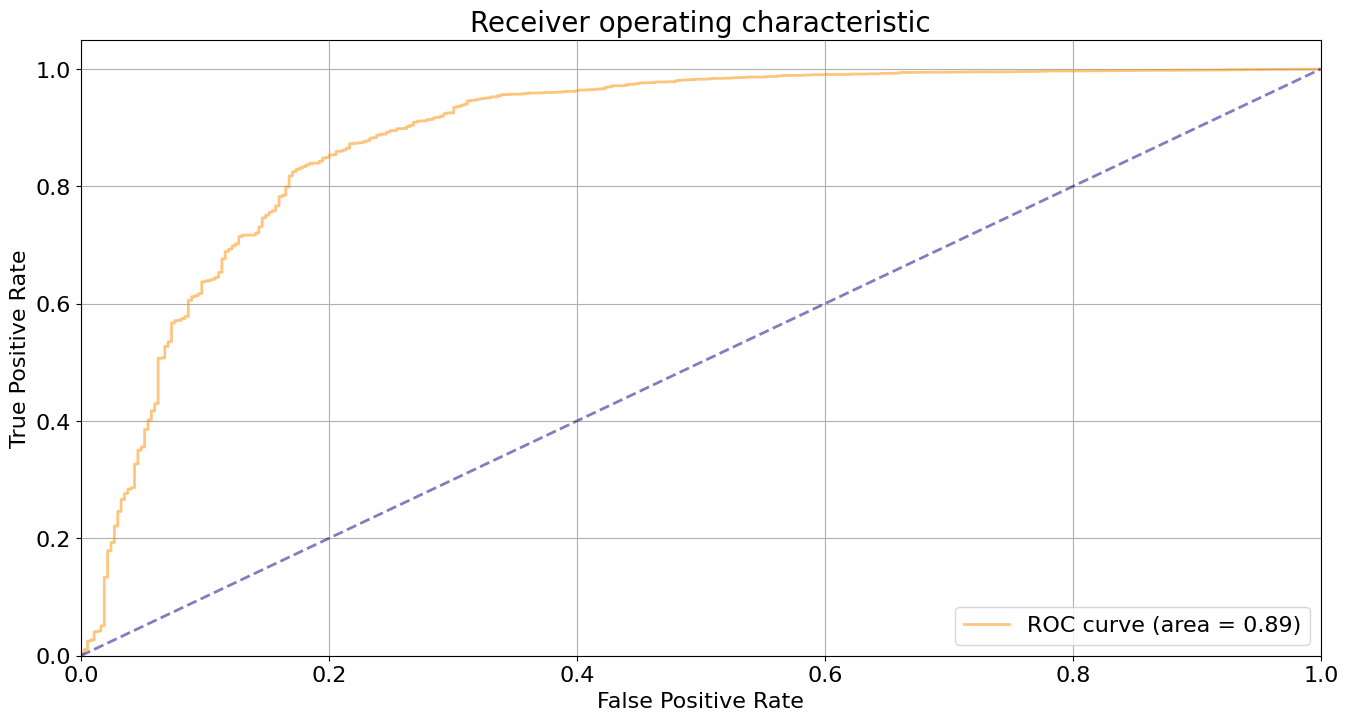

In [49]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [50]:
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

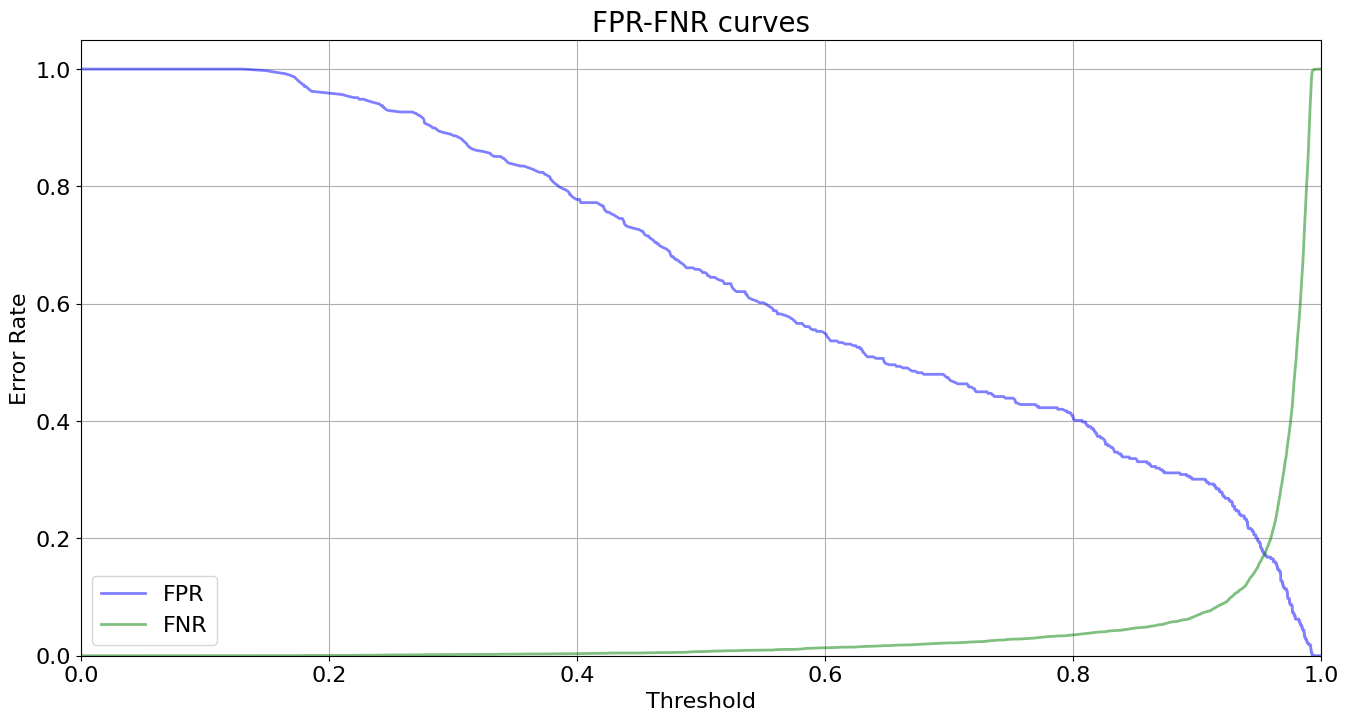

In [51]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [52]:
from catboost.utils import select_threshold

print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.5589790557061969
0.9922433395240446


Получение предсказаний

In [53]:
print(model.predict_proba(X_validation))

[[0.0114 0.9886]
 [0.0185 0.9815]
 [0.0169 0.9831]
 ...
 [0.0119 0.9881]
 [0.0088 0.9912]
 [0.0139 0.9861]]


In [54]:
print(model.predict(X_validation))

[1 1 1 ... 1 1 1]


Последовательные предсказания

In [55]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0,
    ntree_end=5,
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4794 0.5206]
 [0.4794 0.5206]
 [0.4794 0.5206]
 ...
 [0.4794 0.5206]
 [0.4794 0.5206]
 [0.4794 0.5206]]
Iteration 1, predictions:
[[0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]
 ...
 [0.4588 0.5412]
 [0.4588 0.5412]
 [0.4588 0.5412]]
Iteration 2, predictions:
[[0.4397 0.5603]
 [0.4397 0.5603]
 [0.4397 0.5603]
 ...
 [0.4397 0.5603]
 [0.4397 0.5603]
 [0.4397 0.5603]]
Iteration 3, predictions:
[[0.4184 0.5816]
 [0.4184 0.5816]
 [0.4259 0.5741]
 ...
 [0.4184 0.5816]
 [0.4184 0.5816]
 [0.4184 0.5816]]
Iteration 4, predictions:
[[0.4004 0.5996]
 [0.4004 0.5996]
 [0.4078 0.5922]
 ...
 [0.4004 0.5996]
 [0.4004 0.5996]
 [0.4004 0.5996]]


Важность признаков

In [56]:
model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,MGR_ID,23.457070
1,RESOURCE,20.515127
2,ROLE_DEPTNAME,14.267019
3,ROLE_FAMILY_DESC,10.310366
4,ROLE_ROLLUP_2,9.972613
5,ROLE_CODE,7.810630
6,ROLE_TITLE,5.366066
7,ROLE_FAMILY,4.576275
8,ROLE_ROLLUP_1,3.724834


### Shap values

Классические способы измерения важности признаков обладают существенным недостатком: непонятно, как именно каждый признак влияет на предсказание модели. Shap values (значения Шэпли) - способ измерения важности признаков, исправляющий этот недостаток.

Подробнее читайте тут: https://habr.com/ru/post/428213/

In [57]:
import shap

shap_values = model.get_feature_importance(pool1, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

print(shap_values.shape)

(32769, 9)


/var/folders/6k/wpzb0pwn71g3ww4by8xqvb6h0000gn/T/ipykernel_84747/3017445420.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X)


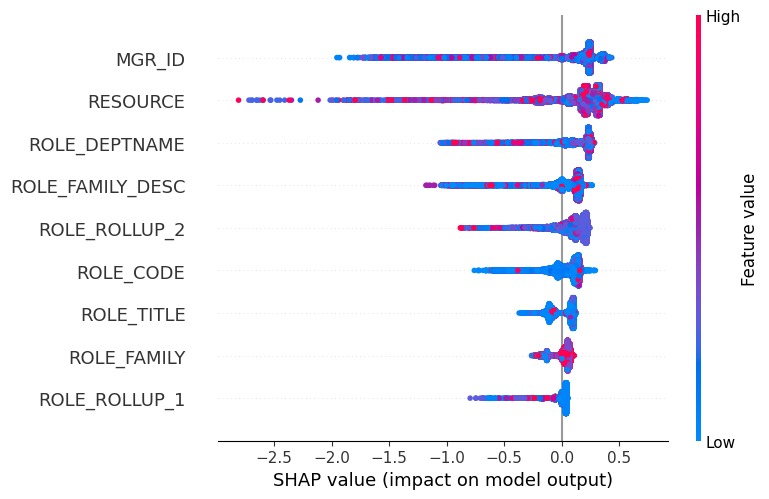

In [58]:
shap.summary_plot(shap_values, X)

Shap-values для конкретного объекта.

In [59]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

Сохранение модели

In [60]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

In [61]:
my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

{'iterations': 10, 'loss_function': 'Logloss', 'verbose': 0}
0


Подбор гиперпараметров

In [59]:
cat = CatBoostClassifier(n_estimators=50)

grid = {'learning_rate': [0.03, 0.1],
        'depth': [4, 6, 10]}
#        'l2_leaf_reg': [1, 3, 5, 7, 9]}

grid_search_result = cat.grid_search(grid, X=X_train, y=y_train, verbose=False, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6563227	test: 0.6566072	best: 0.6566072 (0)	total: 12.1ms	remaining: 594ms
1:	learn: 0.6227276	test: 0.6234014	best: 0.6234014 (1)	total: 19.2ms	remaining: 461ms
2:	learn: 0.5915535	test: 0.5927244	best: 0.5927244 (2)	total: 27.1ms	remaining: 424ms
3:	learn: 0.5626485	test: 0.5641488	best: 0.5641488 (3)	total: 38.6ms	remaining: 444ms
4:	learn: 0.5360495	test: 0.5378118	best: 0.5378118 (4)	total: 48.2ms	remaining: 434ms
5:	learn: 0.5116681	test: 0.5137107	best: 0.5137107 (5)	total: 55.6ms	remaining: 408ms
6:	learn: 0.4891786	test: 0.4914464	best: 0.4914464 (6)	total: 63ms	remaining: 387ms
7:	learn: 0.4684688	test: 0.4710067	best: 0.4710067 (7)	total: 71ms	remaining: 373ms
8:	learn: 0.4494889	test: 0.4523627	best: 0.4523627 (8)	total: 78.9ms	remaining: 359ms
9:	learn: 0.4317230	test: 0.4348204	best: 0.4348204 (9)	total: 87ms	remaining: 348ms
10:	learn: 0.4155908	test: 0.4189671	best: 0.4189671 (10)	total: 98.5ms	remaining: 349ms
11:	learn: 0.4007153	test: 0.4044185	best: 0.40

In [60]:
grid_search_result['params']

{'depth': 10, 'learning_rate': 0.1}

Визуализация деревьев

In [61]:
# Might run into the graphiz problem:
# https://stackoverflow.com/questions/35064304/runtimeerror-make-sure-the-graphviz-executables-are-on-your-systems-path-aft

In [62]:
cat.plot_tree(tree_idx=0)

Хорошее описание гиперпараметров катбуста: https://habr.com/ru/company/otus/blog/527554/

## LightGBM

Особенности LightGBM:

* полиственное (leaf-wise), а не поуровневое (depth-wise) построение деревьев

* быстрое построение дерева, позволяющее не кодировать категориальные признаки, а использовать исходные категории для получения предикатов

* ускорение построения деревьев за счёт бинаризации признаков (объединение значений признака в группы)

Почитать подробнее можно тут: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

In [63]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [64]:
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

import numpy as np

data = load_boston()
X_full = data.data
y_full = data.target

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=100, random_state=241)

ImportError: 
`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    target = raw_df.values[1::2, 2]

Alternative datasets include the California housing dataset and the
Ames housing dataset. You can load the datasets as follows::

    from sklearn.datasets import fetch_california_housing
    housing = fetch_california_housing()

for the California housing dataset and::

    from sklearn.datasets import fetch_openml
    housing = fetch_openml(name="house_prices", as_frame=True)

for the Ames housing dataset.

[1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

[2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>


Обучение

In [ ]:
print('Starting training...')
# train
gbm = lgb.LGBMRegressor(num_leaves=31,
                        learning_rate=0.05,
                        n_estimators=20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=5)

Предсказание и оценка качества

In [ ]:
print('Starting predicting...')

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

Можно задать любую (придумать свою, например) метрику качества

In [ ]:
# self-defined eval metric
# f(y_true: array, y_pred: array) -> name: string, eval_result: float, is_higher_better: bool
# Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y_true, y_pred):
    return 'RMSLE', np.sqrt(np.mean(np.power(np.log1p(y_pred) - np.log1p(y_true), 2))), False


print('Starting training with custom eval function...')
# train
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=rmsle,
        early_stopping_rounds=5)

print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmsle of prediction is:', rmsle(y_test, y_pred)[1])

Подбор гиперпараметров

In [ ]:
# other scikit-learn modules
estimator = lgb.LGBMRegressor(num_leaves=31)

param_grid = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': [20, 40]
}

gbm = GridSearchCV(estimator, param_grid, cv=3)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)

Предсказание и оценка качества

In [ ]:
pred = gbm.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, pred)**0.5